Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression

In [93]:
cars = pd.read_csv('/datasets/autos.csv')
cars.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [94]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


### Загрузил данные, вывел первые строки, посмотрел info

In [95]:
cars.duplicated().sum() 


4

In [96]:
cars = cars.drop_duplicates()
cars.duplicated().sum() 

0

### проверил дубликаты, нашел 4 шт, удалил

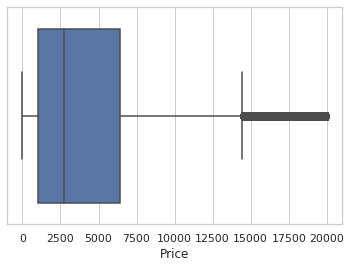

In [97]:
sns.set(style = "whitegrid")
ax = sns.boxplot(x = cars['Price'])

In [98]:
cars = cars.query('Price < 14000')

In [99]:
cars.query('Price < 200').head(20)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
79,2016-03-17 18:52:56,150,NaN,2016,manual,75,astra,150000,3,petrol,opel,yes,2016-03-17 00:00:00,0,78315,2016-04-05 03:45:22
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
145,2016-03-06 21:38:00,150,NaN,1985,NaN,0,100,150000,4,petrol,audi,NaN,2016-03-06 00:00:00,0,87616,2016-04-07 02:16:59
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
154,2016-03-22 16:37:59,0,NaN,2006,NaN,0,other,5000,0,NaN,fiat,NaN,2016-03-22 00:00:00,0,44867,2016-04-06 06:17:56


In [100]:
cars = cars.query('Price > 200')

#### посмотрел распределение суммы автомобилей, удалил выбросы выше 14к и все машины дешевле 200, тк там скорее всего какой то металлолом.

In [101]:
cars.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          30227
RegistrationYear         0
Gearbox              14956
Power                    0
Model                15701
Kilometer                0
RegistrationMonth        0
FuelType             26132
Brand                    0
NotRepaired          60172
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [102]:
cars['VehicleType'] = cars['VehicleType'].fillna('unknown')
cars['Model'] = cars['Model'].fillna('unknown')
cars['Gearbox'] = cars['Gearbox'].fillna('unknown')
cars['FuelType'] = cars['FuelType'].fillna('unknown')
cars['NotRepaired'] = cars['NotRepaired'].fillna('unknown')

In [103]:
cars.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

#### Проверил пропуски, осмысленно их заполнить как мне кажется не представляется возможным. Все пропуски заполнил unknown

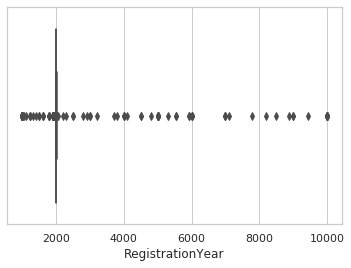

In [104]:
sns.set(style = "whitegrid")
ax1 = sns.boxplot(x = cars['RegistrationYear'])

In [105]:
cars = cars.query('2020 > RegistrationYear > 1986')

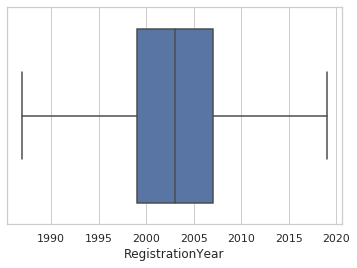

In [106]:
sns.set(style = "whitegrid")
ax1 = sns.boxplot(x = cars['RegistrationYear'])

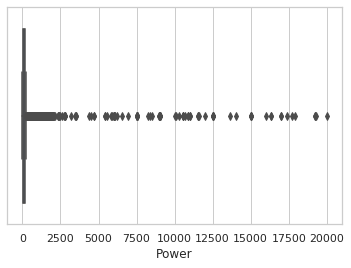

In [107]:
sns.set(style = "whitegrid")
ax2 = sns.boxplot(x = cars['Power'])

In [108]:
cars =  cars.query('10 < Power <  230')

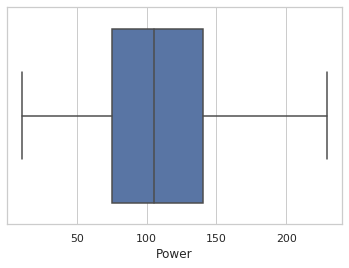

In [109]:
sns.set(style = "whitegrid")
ax2 = sns.boxplot(x = cars['Power'])

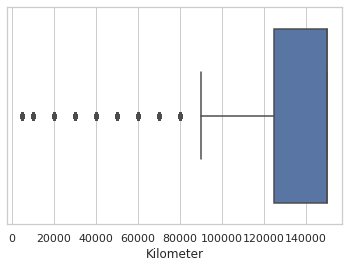

In [110]:
sns.set(style = "whitegrid")
ax3 = sns.boxplot(x = cars['Kilometer'])

In [111]:
cars =  cars.query('60000 < Kilometer ')

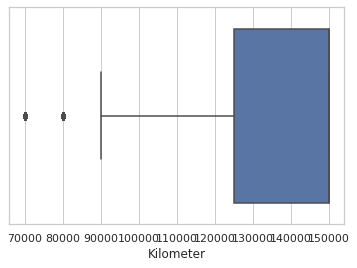

In [112]:
sns.set(style = "whitegrid")
ax3 = sns.boxplot(x = cars['Kilometer'])

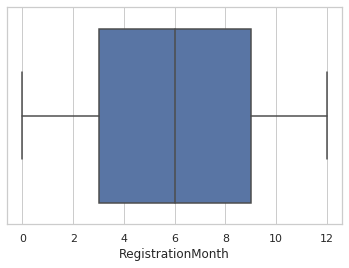

In [113]:
sns.set(style = "whitegrid")
ax3 = sns.boxplot(x = cars['RegistrationMonth'])


### Посмотрел распределение численных колонок датафрейма, удалил выбросы.

In [114]:
cars_coded = cars.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis = 1)

In [115]:
cars_coded = pd.get_dummies(cars_coded, drop_first = True)

In [116]:
cars_coded.head(10)

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,999,1998,101,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
10,2000,2004,105,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11,2799,2005,140,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
12,999,1995,115,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
13,2500,2004,131,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Для обучения моделе удалил колонки которые не окажут никакого эффекта на модели. Перекодировал данные с помощь OHE, удалив первую колонку

# 2. Обучение моделей

In [117]:
target = cars_coded['Price']
features = cars_coded.drop(['Price'], axis = 1)

In [118]:
features_train_0, features_valid, target_train_0, target_valid = train_test_split(
    features, target, test_size = 0.18, random_state = 12345)
features_train, features_test, target_train, target_test = train_test_split(features_train_0, target_train_0, test_size = 0.22, random_state = 12345)

In [119]:
features_train.shape

(158910, 304)

In [120]:
features_test.shape

(44822, 304)

In [121]:
features_valid.shape

(44722, 304)

In [122]:
#for i in range(3, 9):
#    for j in range(20, 40, 5):
#        for l in range(50, 150, 10):
#            model_1 = lgbm.sklearn.LGBMRegressor(max_depth = i, num_leaves = j, n_estimators = l)
#            model_1.fit(features_train, target_train)
#            predictions = model_1.predict(features_valid)
#            mse = mean_squared_error(target_valid, predictions)
#            print('depth', i, 'leaves', j, 'estimators', l, 'RMSE=', mse**0.5)

### Построил модель LGBMRegressor в цикле перебирал 3 параметра, глубина, количество листьев и количество оценщиков. Результат поместил в ячейку ниже тк считается оно очень долго.

- depth 3 leaves 20 estimators 50 RMSE= 1514.7399272913506
- depth 3 leaves 20 estimators 60 RMSE= 1480.063069216852
- depth 3 leaves 20 estimators 70 RMSE= 1455.023287126802
- depth 3 leaves 20 estimators 80 RMSE= 1434.0713414243448
- depth 3 leaves 20 estimators 90 RMSE= 1421.1718141038004
- depth 3 leaves 20 estimators 100 RMSE= 1408.484080322699
- depth 3 leaves 20 estimators 110 RMSE= 1399.3728954142332
- depth 3 leaves 20 estimators 120 RMSE= 1393.7602262589166
- depth 3 leaves 20 estimators 130 RMSE= 1387.9007720580935
- depth 3 leaves 20 estimators 140 RMSE= 1383.2833738257991
- depth 3 leaves 25 estimators 50 RMSE= 1514.7399272913506
- depth 3 leaves 25 estimators 60 RMSE= 1480.063069216852
- depth 3 leaves 25 estimators 70 RMSE= 1455.023287126802
- depth 3 leaves 25 estimators 80 RMSE= 1434.0713414243448
- depth 3 leaves 25 estimators 90 RMSE= 1421.1718141038004
- depth 3 leaves 25 estimators 100 RMSE= 1408.484080322699
- depth 3 leaves 25 estimators 110 RMSE= 1399.3728954142332
- depth 3 leaves 25 estimators 120 RMSE= 1393.7602262589166
- depth 3 leaves 25 estimators 130 RMSE= 1387.9007720580935
- depth 3 leaves 25 estimators 140 RMSE= 1383.2833738257991
- depth 3 leaves 30 estimators 50 RMSE= 1514.7399272913506
- depth 3 leaves 30 estimators 60 RMSE= 1480.063069216852
- depth 3 leaves 30 estimators 70 RMSE= 1455.023287126802
- depth 3 leaves 30 estimators 80 RMSE= 1434.0713414243448
- depth 3 leaves 30 estimators 90 RMSE= 1421.1718141038004
- depth 3 leaves 30 estimators 100 RMSE= 1408.484080322699
- depth 3 leaves 30 estimators 110 RMSE= 1399.3728954142332
- depth 3 leaves 30 estimators 120 RMSE= 1393.7602262589166
- depth 3 leaves 30 estimators 130 RMSE= 1387.9007720580935
- depth 3 leaves 30 estimators 140 RMSE= 1383.2833738257991
- depth 3 leaves 35 estimators 50 RMSE= 1514.7399272913506
- depth 3 leaves 35 estimators 60 RMSE= 1480.063069216852
- depth 3 leaves 35 estimators 70 RMSE= 1455.023287126802
- depth 3 leaves 35 estimators 80 RMSE= 1434.0713414243448
- depth 3 leaves 35 estimators 90 RMSE= 1421.1718141038004
- depth 3 leaves 35 estimators 100 RMSE= 1408.484080322699
- depth 3 leaves 35 estimators 110 RMSE= 1399.3728954142332
- depth 3 leaves 35 estimators 120 RMSE= 1393.7602262589166
- depth 3 leaves 35 estimators 130 RMSE= 1387.9007720580935
- depth 3 leaves 35 estimators 140 RMSE= 1383.2833738257991
- depth 4 leaves 20 estimators 50 RMSE= 1420.9046728089777
- depth 4 leaves 20 estimators 60 RMSE= 1393.5743308655524
- depth 4 leaves 20 estimators 70 RMSE= 1376.8776312534305
- depth 4 leaves 20 estimators 80 RMSE= 1364.4009366809842
- depth 4 leaves 20 estimators 90 RMSE= 1353.9333770181413
- depth 4 leaves 20 estimators 100 RMSE= 1345.959595484614
- depth 4 leaves 20 estimators 110 RMSE= 1338.5152255886196
- depth 4 leaves 20 estimators 120 RMSE= 1332.1371324096222
- depth 4 leaves 20 estimators 130 RMSE= 1327.1755622747141
- depth 4 leaves 20 estimators 140 RMSE= 1323.602201087998
- depth 4 leaves 25 estimators 50 RMSE= 1420.9046728089777
- depth 4 leaves 25 estimators 60 RMSE= 1393.5743308655524
- depth 4 leaves 25 estimators 70 RMSE= 1376.8776312534305
- depth 4 leaves 25 estimators 80 RMSE= 1364.4009366809842
- depth 4 leaves 25 estimators 90 RMSE= 1353.9333770181413
- depth 4 leaves 25 estimators 100 RMSE= 1345.959595484614
- depth 4 leaves 25 estimators 110 RMSE= 1338.5152255886196
- depth 4 leaves 25 estimators 120 RMSE= 1332.1371324096222
- depth 4 leaves 25 estimators 130 RMSE= 1327.1755622747141
- depth 4 leaves 25 estimators 140 RMSE= 1323.602201087998
- depth 4 leaves 30 estimators 50 RMSE= 1420.9046728089777
- depth 4 leaves 30 estimators 60 RMSE= 1393.5743308655524
- depth 4 leaves 30 estimators 70 RMSE= 1376.8776312534305
- depth 4 leaves 30 estimators 80 RMSE= 1364.4009366809842
- depth 4 leaves 30 estimators 90 RMSE= 1353.9333770181413
- depth 4 leaves 30 estimators 100 RMSE= 1345.959595484614
- depth 4 leaves 30 estimators 110 RMSE= 1338.5152255886196
- depth 4 leaves 30 estimators 120 RMSE= 1332.1371324096222
- depth 4 leaves 30 estimators 130 RMSE= 1327.1755622747141
- depth 4 leaves 30 estimators 140 RMSE= 1323.602201087998
- depth 4 leaves 35 estimators 50 RMSE= 1420.9046728089777
- depth 4 leaves 35 estimators 60 RMSE= 1393.5743308655524
- depth 4 leaves 35 estimators 70 RMSE= 1376.8776312534305
- depth 4 leaves 35 estimators 80 RMSE= 1364.4009366809842
- depth 4 leaves 35 estimators 90 RMSE= 1353.9333770181413
- depth 4 leaves 35 estimators 100 RMSE= 1345.959595484614
- depth 4 leaves 35 estimators 110 RMSE= 1338.5152255886196
- depth 4 leaves 35 estimators 120 RMSE= 1332.1371324096222
- depth 4 leaves 35 estimators 130 RMSE= 1327.1755622747141
- depth 4 leaves 35 estimators 140 RMSE= 1323.602201087998
- depth 5 leaves 20 estimators 50 RMSE= 1373.651939869364
- depth 5 leaves 20 estimators 60 RMSE= 1352.8991108276418
- depth 5 leaves 20 estimators 70 RMSE= 1338.975573348422
- depth 5 leaves 20 estimators 80 RMSE= 1327.3439865309883
- depth 5 leaves 20 estimators 90 RMSE= 1319.050924057414
- depth 5 leaves 20 estimators 100 RMSE= 1311.7903023670026
- depth 5 leaves 20 estimators 110 RMSE= 1305.8823186433824
- depth 5 leaves 20 estimators 120 RMSE= 1301.1079113492012
- depth 5 leaves 20 estimators 130 RMSE= 1296.077794569502
- depth 5 leaves 20 estimators 140 RMSE= 1289.532380888635
- depth 5 leaves 25 estimators 50 RMSE= 1366.7792029552636
- depth 5 leaves 25 estimators 60 RMSE= 1344.6839547206903
- depth 5 leaves 25 estimators 70 RMSE= 1332.0065797615175
- depth 5 leaves 25 estimators 80 RMSE= 1321.8200679315876
- depth 5 leaves 25 estimators 90 RMSE= 1315.3113837761912
- depth 5 leaves 25 estimators 100 RMSE= 1306.9947487776526
- depth 5 leaves 25 estimators 110 RMSE= 1301.85543490185
- depth 5 leaves 25 estimators 120 RMSE= 1297.015636157233
- depth 5 leaves 25 estimators 130 RMSE= 1291.85424862904
- depth 5 leaves 25 estimators 140 RMSE= 1288.2427495573518
- depth 5 leaves 30 estimators 50 RMSE= 1362.2884580243908
- depth 5 leaves 30 estimators 60 RMSE= 1343.4621441627226
- depth 5 leaves 30 estimators 70 RMSE= 1327.2922562292313
- depth 5 leaves 30 estimators 80 RMSE= 1317.6437190243114
- depth 5 leaves 30 estimators 90 RMSE= 1310.6807884819236
- depth 5 leaves 30 estimators 100 RMSE= 1304.0016678015502
- depth 5 leaves 30 estimators 110 RMSE= 1299.0002111300046
- depth 5 leaves 30 estimators 120 RMSE= 1293.8753282384978
- depth 5 leaves 30 estimators 130 RMSE= 1289.796553665602
- depth 5 leaves 30 estimators 140 RMSE= 1285.7118981362464
- depth 5 leaves 35 estimators 50 RMSE= 1363.6215686674939
- depth 5 leaves 35 estimators 60 RMSE= 1343.3354940774984
- depth 5 leaves 35 estimators 70 RMSE= 1329.7329000225834
- depth 5 leaves 35 estimators 80 RMSE= 1319.8057593852354
- depth 5 leaves 35 estimators 90 RMSE= 1311.8294676504115
- depth 5 leaves 35 estimators 100 RMSE= 1304.6832525137634
- depth 5 leaves 35 estimators 110 RMSE= 1299.9732208343885
- depth 5 leaves 35 estimators 120 RMSE= 1295.0357104416175
- depth 5 leaves 35 estimators 130 RMSE= 1289.8892294098357
- depth 5 leaves 35 estimators 140 RMSE= 1285.7760218002518
- depth 6 leaves 20 estimators 50 RMSE= 1357.2845793939728
- depth 6 leaves 20 estimators 60 RMSE= 1338.579198043443
- depth 6 leaves 20 estimators 70 RMSE= 1325.2357686294556
- depth 6 leaves 20 estimators 80 RMSE= 1316.322139772992
- depth 6 leaves 20 estimators 90 RMSE= 1306.645085095532
- depth 6 leaves 20 estimators 100 RMSE= 1299.027951586069
- depth 6 leaves 20 estimators 110 RMSE= 1292.7691496874868
- depth 6 leaves 20 estimators 120 RMSE= 1287.1902399548462
- depth 6 leaves 20 estimators 130 RMSE= 1281.885135409587
- depth 6 leaves 20 estimators 140 RMSE= 1278.27850268727
- depth 6 leaves 25 estimators 50 RMSE= 1345.7289593963048
- depth 6 leaves 25 estimators 60 RMSE= 1327.30205805102
- depth 6 leaves 25 estimators 70 RMSE= 1314.742086029416
- depth 6 leaves 25 estimators 80 RMSE= 1304.7768007386696
- depth 6 leaves 25 estimators 90 RMSE= 1296.2471899941406
- depth 6 leaves 25 estimators 100 RMSE= 1289.524769930247
- depth 6 leaves 25 estimators 110 RMSE= 1283.4223389508688
- depth 6 leaves 25 estimators 120 RMSE= 1277.4806407417727
- depth 6 leaves 25 estimators 130 RMSE= 1272.8226179778062
- depth 6 leaves 25 estimators 140 RMSE= 1268.4485048112147
- depth 6 leaves 30 estimators 50 RMSE= 1336.593550364486
- depth 6 leaves 30 estimators 60 RMSE= 1320.7739374939774
- depth 6 leaves 30 estimators 70 RMSE= 1307.5948431904972
- depth 6 leaves 30 estimators 80 RMSE= 1299.4485907742476
- depth 6 leaves 30 estimators 90 RMSE= 1292.9915098437432
- depth 6 leaves 30 estimators 100 RMSE= 1287.4678314503776
- depth 6 leaves 30 estimators 110 RMSE= 1280.7827938781534
- depth 6 leaves 30 estimators 120 RMSE= 1277.0287916568382
- depth 6 leaves 30 estimators 130 RMSE= 1270.5897333781732
- depth 6 leaves 30 estimators 140 RMSE= 1265.2633865898108
- depth 6 leaves 35 estimators 50 RMSE= 1331.4004759653874
- depth 6 leaves 35 estimators 60 RMSE= 1313.9498022274136
- depth 6 leaves 35 estimators 70 RMSE= 1303.1150130926462
- depth 6 leaves 35 estimators 80 RMSE= 1293.8423244785884
- depth 6 leaves 35 estimators 90 RMSE= 1287.1500281570834
- depth 6 leaves 35 estimators 100 RMSE= 1280.9966773369067
- depth 6 leaves 35 estimators 110 RMSE= 1275.3611185225332
- depth 6 leaves 35 estimators 120 RMSE= 1271.7382177217116
- depth 6 leaves 35 estimators 130 RMSE= 1267.7449297630149
- depth 6 leaves 35 estimators 140 RMSE= 1263.682380700743
- depth 7 leaves 20 estimators 50 RMSE= 1352.541833435654
- depth 7 leaves 20 estimators 60 RMSE= 1331.7397181481026
- depth 7 leaves 20 estimators 70 RMSE= 1317.6909140658186
- depth 7 leaves 20 estimators 80 RMSE= 1307.8068469649945
- depth 7 leaves 20 estimators 90 RMSE= 1299.5773727468054
- depth 7 leaves 20 estimators 100 RMSE= 1293.0149582384583
- depth 7 leaves 20 estimators 110 RMSE= 1286.683781649532
- depth 7 leaves 20 estimators 120 RMSE= 1280.6327289856235
- depth 7 leaves 20 estimators 130 RMSE= 1276.3721125367774
- depth 7 leaves 20 estimators 140 RMSE= 1271.7983963808863
- depth 7 leaves 25 estimators 50 RMSE= 1336.011329003642
- depth 7 leaves 25 estimators 60 RMSE= 1318.0012523884877
- depth 7 leaves 25 estimators 70 RMSE= 1304.9426838374775
- depth 7 leaves 25 estimators 80 RMSE= 1296.483169226072
- depth 7 leaves 25 estimators 90 RMSE= 1288.8716564487622
- depth 7 leaves 25 estimators 100 RMSE= 1282.3440346054995
- depth 7 leaves 25 estimators 110 RMSE= 1275.7264160527293
- depth 7 leaves 25 estimators 120 RMSE= 1270.1523127848413
- depth 7 leaves 25 estimators 130 RMSE= 1265.6742395949416
- depth 7 leaves 25 estimators 140 RMSE= 1262.2538674885777
- depth 7 leaves 30 estimators 50 RMSE= 1325.8155600045268
- depth 7 leaves 30 estimators 60 RMSE= 1308.7950600324775
- depth 7 leaves 30 estimators 70 RMSE= 1295.8075714788235
- depth 7 leaves 30 estimators 80 RMSE= 1287.7102332527766
- depth 7 leaves 30 estimators 90 RMSE= 1280.805565426598
- depth 7 leaves 30 estimators 100 RMSE= 1273.5203773077335
- depth 7 leaves 30 estimators 110 RMSE= 1267.6607680252368
- depth 7 leaves 30 estimators 120 RMSE= 1263.1126859947228
- depth 7 leaves 30 estimators 130 RMSE= 1259.7982259249695
- depth 7 leaves 30 estimators 140 RMSE= 1256.886702359421
- depth 7 leaves 35 estimators 50 RMSE= 1312.4463146243904
- depth 7 leaves 35 estimators 60 RMSE= 1296.0384088171609
- depth 7 leaves 35 estimators 70 RMSE= 1283.9160092341322
- depth 7 leaves 35 estimators 80 RMSE= 1276.6772110973195
- depth 7 leaves 35 estimators 90 RMSE= 1269.3587329772213
- depth 7 leaves 35 estimators 100 RMSE= 1263.1343231652256
- depth 7 leaves 35 estimators 110 RMSE= 1259.4164262983068
- depth 7 leaves 35 estimators 120 RMSE= 1255.845419712685
- depth 7 leaves 35 estimators 130 RMSE= 1251.7303303211804
- depth 7 leaves 35 estimators 140 RMSE= 1248.4628754549533
- depth 8 leaves 20 estimators 50 RMSE= 1347.229045617483
- depth 8 leaves 20 estimators 60 RMSE= 1327.217019309915
- depth 8 leaves 20 estimators 70 RMSE= 1313.0987881564565
- depth 8 leaves 20 estimators 80 RMSE= 1302.897811724003
- depth 8 leaves 20 estimators 90 RMSE= 1294.6885940501472
- depth 8 leaves 20 estimators 100 RMSE= 1288.2384186222935
- depth 8 leaves 20 estimators 110 RMSE= 1282.697290190336
- depth 8 leaves 20 estimators 120 RMSE= 1276.8823705772713
- depth 8 leaves 20 estimators 130 RMSE= 1272.1944766385302
- depth 8 leaves 20 estimators 140 RMSE= 1268.0511518082685
- depth 8 leaves 25 estimators 50 RMSE= 1330.3925385277066
- depth 8 leaves 25 estimators 60 RMSE= 1313.3305569253412
- depth 8 leaves 25 estimators 70 RMSE= 1299.5554988046188
- depth 8 leaves 25 estimators 80 RMSE= 1290.247246455967
- depth 8 leaves 25 estimators 90 RMSE= 1282.9290760178094
- depth 8 leaves 25 estimators 100 RMSE= 1275.8446139315422
- depth 8 leaves 25 estimators 110 RMSE= 1270.284435458909
- depth 8 leaves 25 estimators 120 RMSE= 1265.6155949638248
- depth 8 leaves 25 estimators 130 RMSE= 1260.6027907317014
- depth 8 leaves 25 estimators 140 RMSE= 1256.7284248912601
- depth 8 leaves 30 estimators 50 RMSE= 1320.248970946348
- depth 8 leaves 30 estimators 60 RMSE= 1303.140472472132
- depth 8 leaves 30 estimators 70 RMSE= 1291.0297278429018
- depth 8 leaves 30 estimators 80 RMSE= 1281.9794166746005
- depth 8 leaves 30 estimators 90 RMSE= 1274.9968363125565
- depth 8 leaves 30 estimators 100 RMSE= 1268.9057665761195
- depth 8 leaves 30 estimators 110 RMSE= 1264.289027347777
- depth 8 leaves 30 estimators 120 RMSE= 1259.0981870315172
- depth 8 leaves 30 estimators 130 RMSE= 1255.480528515237
- depth 8 leaves 30 estimators 140 RMSE= 1252.4103798472008
- depth 8 leaves 35 estimators 50 RMSE= 1308.7554228204951
- depth 8 leaves 35 estimators 60 RMSE= 1292.5960625888079
- depth 8 leaves 35 estimators 70 RMSE= 1280.4928151274294
- depth 8 leaves 35 estimators 80 RMSE= 1272.8378042709219
- depth 8 leaves 35 estimators 90 RMSE= 1265.7259513942925
- depth 8 leaves 35 estimators 100 RMSE= 1260.4237860587752
- depth 8 leaves 35 estimators 110 RMSE= 1256.1598010416492
- depth 8 leaves 35 estimators 120 RMSE= 1251.5096490025228
- depth 8 leaves 35 estimators 130 RMSE= 1247.035394827383
- depth 8 leaves 35 estimators 140 RMSE= 1244.0649347934357


In [123]:

model_2 = lgbm.sklearn.LGBMRegressor(boosting_type='dart', max_depth = 8, num_leaves = 35, n_estimators = 140)
model_2.fit(features_train, target_train)
predictions_2 = model_2.predict(features_valid)
mse = mean_squared_error(target_valid, predictions_2)
print(mse**0.5)

1408.0440770797204


### с лучшим результатом я решил проверить что получится если поменять boosting type на dart однако результат стал хуже.

# 3. Анализ моделей

### Для сравнения результатов я сравню LGBMRegressor с лушими показателями из цикла и стандартную линейную регрессию, обученую на тех же данных, в конце проверю модели на тестевых данных. У каждой ячейки засеку время выполнения

In [124]:
%%time
model_2 = lgbm.sklearn.LGBMRegressor(max_depth = 8, num_leaves = 35, n_estimators = 140)
model_2.fit(features_train, target_train)
predictions_2 = model_2.predict(features_valid)
mse = mean_squared_error(target_valid, predictions_2)
print(mse**0.5)

1244.0649347934357
CPU times: user 9.06 s, sys: 312 ms, total: 9.37 s
Wall time: 9.49 s


In [125]:
%%time
model_3 = LinearRegression()
model_3.fit(features_train, target_train)
predictions_3 = model_3.predict(features_valid)
mse = mean_squared_error(target_valid, predictions_3)
print(mse**0.5)

1719.9535145477437
CPU times: user 11 s, sys: 4.48 s, total: 15.5 s
Wall time: 15.5 s


### Общее время линейной регрессии оказалось выше и результат занчительно хуже

In [126]:
%%time
predictions_4 = model_2.predict(features_test)
mse = mean_squared_error(target_test, predictions_4)
print(mse**0.5)

1231.2775336303303
CPU times: user 888 ms, sys: 64 ms, total: 952 ms
Wall time: 908 ms


In [127]:
%%time
predictions_5 = model_3.predict(features_test)
mse = mean_squared_error(target_test, predictions_5)
print(mse**0.5)

1720.3510068887595
CPU times: user 72 ms, sys: 88 ms, total: 160 ms
Wall time: 188 ms


### тот же результат на тестевых данных, однако линейная регрессия делает предсказаниче немного быстрее

### По полученным результатам можно мделать вывод что я добился нужного результата, LGBMRegressor показывает хороший и быстрый результат, при сравнеии с линейной регрессией